# Arithmetic Encoding

La codificación aritmética es una técnica de compresión de datos sin pérdida. , codifica un mensaje completo como un único número real de precisión arbitraria dentro de un intervalo semiabierto [0, 1)

## Intervalo Unitario

Todo el flujo de datos puede representarse mediante una fracción extremadamente larga.
 
- Se comienza con un intervalo inicial de [0, 1).
- A medida que se procesa cada símbolo, el intervalo se va estrechando proporcionalmente a la probabilidad de dicho símbolo.

En este caso debido a que no hay una precisión infinita conforme de va expandiendo el intervalo va perdiendo precisión, por ello surge la normalización

## Normalización

La normalización es el mecanismo para mantener el proceso de mantener la precisión finita dentro de un algorítmo,
que requiere precisión infinita. Nos permite evitar perder precisión y emitir bits progresivamente

### Código

In [1]:
%%writefile -a ../src/ArithmeticCode.py

from collections import OrderedDict


def bits_to_bytes(bits):
    while len(bits) % 8 != 0:
        bits.append(0)
    result = bytearray()
    for i in range(0, len(bits), 8):
        byte = 0
        for b in bits[i:i + 8]:
            byte = (byte << 1) | b
        result.append(byte)
    return bytes(result)


def bytes_to_bits(data):
    bits = []
    for byte in data:
        for i in range(7, -1, -1):
            bits.append((byte >> i) & 1)
    return bits


# Real number out of range 8
def EOF():
    return 256


class FrequencyTable:
    def __init__(self):
        self.alphabet = []
        self.frequencies = OrderedDict()
        self.nsymbols = 0

    def add(self, symbol):
        self.nsymbols += 1
        if symbol in self.frequencies:
            self.frequencies[symbol] += 1
        else:
            self.alphabet.append(symbol)
            self.frequencies[symbol] = 1

    def calculateProbabilities(self):
        probabilities = {}
        for symbol in self.alphabet:
            probabilities[symbol] = self.frequencies[symbol] / self.nsymbols

        ranges = {}
        accumulate = 0.0
        for symbol in self.alphabet:
            ranges[symbol] = (accumulate, accumulate + probabilities[symbol])
            accumulate += probabilities[symbol]

        return probabilities, ranges

    def show_table(self):
        print(f"\n{'=' * 80}")
        print(f"{'Symbol':<10} | {'Frequency':<10} | {'Probability':<12} | {'Low':<12} | {'High':<12}")
        print(f"{'=' * 80}")

        probabilities, accumulate_range = self.calculateProbabilities()

        for symbol in sorted(self.alphabet):
            f = self.frequencies[symbol]
            p = probabilities[symbol]
            low, high = accumulate_range[symbol]
            print(f"{str(symbol):<10} | {f:<10} | {p:<12.6f} | {low:<12.6f} | {high:<12.6f}")

        print(f"{'=' * 80}\n")


class ArithmeticCodding:
    def __init__(self, precision=32):
        self.precision = precision
        self.max_val = (1 << precision) - 1
        self.half = 1 << (precision - 1)
        self.quarter = self.half >> 1

    def encode(self, message, show_table=True):
        frequencytable = FrequencyTable()
        for c in message:
            frequencytable.add(c)

        if show_table:
            frequencytable.show_table()

        total = frequencytable.nsymbols
        symbols = list(frequencytable.frequencies.keys())
        freqs = list(frequencytable.frequencies.values())

        cumulative = {}
        acc = 0
        for s, f in zip(symbols, freqs):
            cumulative[s] = (acc, acc + f)
            acc += f

        low, high = 0, self.max_val
        bits = []
        pending = 0

        for symbol in message:
            r_low, r_high = cumulative[symbol]
            range_width = high - low + 1
            high = low + (range_width * r_high // total) - 1
            low = low + (range_width * r_low // total)

            while True:
                if high < self.half:
                    bits.append(0)
                    bits.extend([1] * pending)
                    pending = 0
                elif low >= self.half:
                    bits.append(1)
                    bits.extend([0] * pending)
                    pending = 0
                    low -= self.half
                    high -= self.half
                elif low >= self.quarter and high < 3 * self.quarter:
                    pending += 1
                    low -= self.quarter
                    high -= self.quarter
                else:
                    break

                low <<= 1
                high = (high << 1) | 1

        pending += 1
        if low < self.quarter:
            bits.append(0)
            bits.extend([1] * pending)
        else:
            bits.append(1)
            bits.extend([0] * pending)

        return bits, frequencytable

    def write(self, filename, bits, table):
        with open(filename, "wb") as f:
            # símbolos distintos
            f.write(len(table.frequencies).to_bytes(2, "big"))

            # tabla de frecuencias
            for s, freq in table.frequencies.items():
                f.write(s.to_bytes(2, "big"))
                f.write(freq.to_bytes(4, "big"))

            # bits comprimidos
            data = bits_to_bytes(bits)
            f.write(data)

    def read(self, filename):
        with open(filename, "rb") as f:
            n_symbols = int.from_bytes(f.read(2), "big")

            table = FrequencyTable()
            for _ in range(n_symbols):
                symbol = int.from_bytes(f.read(2), "big")
                freq = int.from_bytes(f.read(4), "big")
                table.frequencies[symbol] = freq
                table.alphabet.append(symbol)
                table.nsymbols += freq

            bits = bytes_to_bits(f.read())
        return bits, table

    def decode(self, bits, table):
        total = table.nsymbols
        cumulative = {}
        acc = 0
        for s in table.alphabet:
            cumulative[s] = (acc, acc + table.frequencies[s])
            acc += table.frequencies[s]

        low, high = 0, self.max_val
        code = 0
        bit_iter = iter(bits)

        for _ in range(self.precision):
            code = (code << 1) | next(bit_iter, 0)

        result = []

        while True:
            range_width = high - low + 1
            value = ((code - low + 1) * total - 1) // range_width

            for s, (r_low, r_high) in cumulative.items():
                if r_low <= value < r_high:
                    if s == EOF():
                        return result
                    result.append(s)
                    high = low + (range_width * r_high // total) - 1
                    low = low + (range_width * r_low // total)
                    break

            while True:
                if high < self.half:
                    pass
                elif low >= self.half:
                    low -= self.half
                    high -= self.half
                    code -= self.half
                elif low >= self.quarter and high < 3 * self.quarter:
                    low -= self.quarter
                    high -= self.quarter
                    code -= self.quarter
                else:
                    break

                low <<= 1
                high = (high << 1) | 1
                code = (code << 1) | next(bit_iter, 0)

        return result


if __name__ == "__main__":
    arith = ArithmeticCodding()
    message = "Esto es un texto de prueba"
    data = list(message.encode("utf-8"))
    data.append(EOF())

    print("Codificando: ...")
    print(message)

    bits, table = arith.encode(data)
    arith.write("compressed.bin", bits, table)

    bits2, table2 = arith.read("compressed.bin")
    print("Decodificado: ...")
    decoded = arith.decode(bits2, table2)

    decoded_text = bytes(decoded).decode("utf-8")

    print(decoded_text)

Writing ../src/ArithmeticCode.py


In [2]:
%%writefile -a ../src/arith.py

'''Entropy Encoding of images Arithmetic Coding'''
import io
import numpy as np
import main
import logging
import os
# Get description temp file
import tempfile
# Fix substitute hardcode temp file with identification with library tempfile
desc_path = os.path.join(tempfile.gettempdir(),"description.txt")
with open(desc_path, 'w') as f:  # Used by parser.py
    f.write(__doc__)
import parser
import entropy_image_coding as EIC
import heapq
from collections import defaultdict, Counter
import gzip
import pickle
from bitarray import bitarray
import math
from ArithmeticCode import ArithmeticCodding,FrequencyTable,EOF


class CoDec(EIC.CoDec):
    
    def __init__(self, args):
        logging.debug(f"trace args={args}")
        super().__init__(args)
        self.file_extension = ".ari"
    

    def compress_fn(self, img, fn):
        logging.debug(f"trace img={img}")
        arith_fn = f"{fn}_nadap_arith.pkl.gz"
        compressed_img = io.BytesIO()

        encoder = ArithmeticCodding()

        # Flatten the array and convert to a list
        flattened_img = img.flatten().tolist()
        
        # convert to symbols

        # Add EOF symbol, we use the determinate in the algorithm
        flattened_img.append(EOF())

        # Encode the flattened array and gets the bits and frequency table
        bits,table = encoder.encode(flattened_img,show_table=False)

        # Write encoded image and original shape to compressed_img
        bit_bytes = self.bits_to_bytes(bits)  # Save encoded data as bytes
        compressed_img.write(bit_bytes)

        # Compress and save shape and the Huffman Tree
        logging.debug(f"Saving {arith_fn}")
        with gzip.open(arith_fn, 'wb') as f:
            np.save(f, img.shape)
            pickle.dump(table.frequencies, f)  # `gzip.open` compresses the pickle data

        return compressed_img

    def compress(self, img, fn="/tmp/encoded"):
        return self.compress_fn(img, fn)
    
    def decompress_fn(self, compressed_img, fn):
        logging.debug(f"trace compressed_img={compressed_img[:10]}")
        arith_fn = f"{fn}_nadap_arith.pkl.gz"
        compressed_img = io.BytesIO(compressed_img)

        decoder = ArithmeticCodding()
        # Load the shape and the Huffman Tree from the compressed file
        with gzip.open(arith_fn, 'rb') as f:
            shape = np.load(f)
            frequencies = pickle.load(f)

        table = FrequencyTable()

        # Build frequency table
        
        for symbol, freq in frequencies.items():
            table.frequencies[symbol] = freq
            table.alphabet.append(symbol)
            table.nsymbols += freq

        bits = self.bytes_to_bits(compressed_img.read())

        decoded_symbols = decoder.decode(bits,table)

        

        # Reshape decoded data to original shape
        img = np.array(decoded_symbols, dtype=np.uint8).reshape(shape)
        return img

    def decompress(self, compressed_img, fn="/tmp/encoded"):
        return self.decompress_fn(compressed_img, fn)

    def bits_to_bytes(self,bits):
        while len(bits) % 8 != 0:
            bits.append(0)
        result = bytearray()
        for i in range(0, len(bits), 8):
            byte = 0
            for b in bits[i:i + 8]:
                byte = (byte << 1) | b
            result.append(byte)
        return bytes(result)


    def bytes_to_bits(self,data):
        bits = []
        for byte in data:
            for i in range(7, -1, -1):
                bits.append((byte >> i) & 1)
        return bits

if __name__ == "__main__":
    main.main(parser.parser, logging, CoDec)




Writing ../src/arith.py


### Uso VCF

In [3]:
from IPython.display import Image, display

Downloaded http://www.hpca.ual.es/~vruiz/images/pajarillo_512x512.png


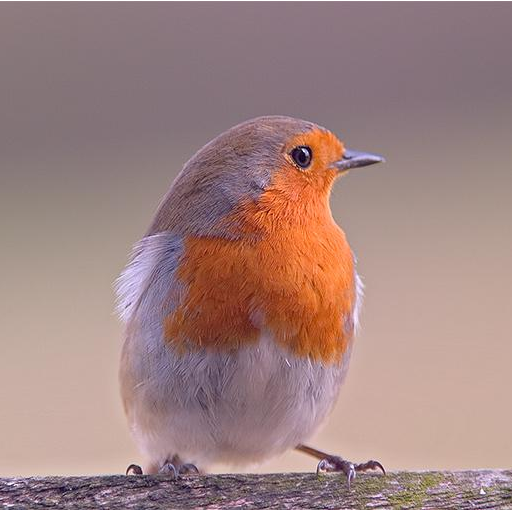

In [4]:
%run download_default_image.ipynb

In [5]:
!python ../src/arith.py -h

usage: arith.py [-h] [-g] {encode,decode} ...

Entropy Encoding of images Arithmetic Coding

positional arguments:
  {encode,decode}  You must specify one of the following subcomands:
    encode         Compress data
    decode         Uncompress data

options:
  -h, --help       show this help message and exit
  -g, --debug      Output debug information (default: False)


In [6]:
!python ../src/arith.py encode -h

usage: arith.py encode [-h] [-o ORIGINAL] [-e ENCODED]

options:
  -h, --help            show this help message and exit
  -o ORIGINAL, --original ORIGINAL
                        Input image (default: /tmp/original.png)
  -e ENCODED, --encoded ENCODED
                        Output image (default: /tmp/encoded)


In [7]:
%%bash
rm /tmp/encoded*
python ../src/arith.py encode

rm: no se puede borrar '/tmp/encoded*': No existe el archivo o el directorio
(INFO) entropy_image_coding: Written 694489 bytes in /tmp/encoded.ari


main Namespace(debug=False, subparser_name='encode', original='/tmp/original.png', encoded='/tmp/encoded', func=<function encode at 0x71cb42d15c60>)


In [8]:
!python ../src/arith.py decode -h

usage: arith.py decode [-h] [-e ENCODED] [-d DECODED]

options:
  -h, --help            show this help message and exit
  -e ENCODED, --encoded ENCODED
                        Input code-stream (default: /tmp/encoded)
  -d DECODED, --decoded DECODED
                        Output image (default: /tmp/decoded.png)


In [9]:
%%bash
python ../src/arith.py decode

main Namespace(debug=False, subparser_name='decode', encoded='/tmp/encoded', decoded='/tmp/decoded.png', func=<function decode at 0x73b187d86d40>)


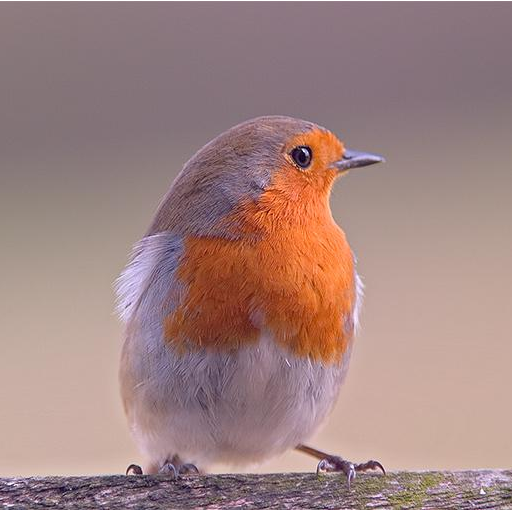

In [10]:
display(Image(filename="/tmp/decoded.png"))

In [11]:
%%bash
python ../src/RDE.py

Code-stream file: /tmp/encoded_nadap_arith.pkl.gz length: 1151
Code-stream file: /tmp/encoded.ari length: 694489
Original image: /tmp/original.png 215071 bytes (6.56) bits/pixel
Code-stream: ['/tmp/encoded_nadap_arith.pkl.gz', '/tmp/encoded.ari'] 695640 bytes (21.23) bits/pixel
Decoded image: /tmp/decoded.png 215071 bytes (6.56) bits/pixel
Images shape: (512, 512, 3)
Distortion (RMSE): 0.00
J = R + D = 21.23


In [12]:
%%bash
rm /tmp/encoded*
rm ../src/arith.py ../src/ArithmeticCode.py

Grupo:
- Jaime Parra Jiménez
- Alejandro Sánchez Rodríguez